# Телеком

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Исследовательский анализ

In [1]:
# Импортируем библиотеки

import imp
import pandas as pd
import numpy as np

from pathlib import Path
from tqdm import notebook

from sklearn.model_selection import (
    train_test_split, RepeatedKFold, cross_val_score, GridSearchCV)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, make_scorer, log_loss
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

from catboost import CatBoostClassifier, CatBoost
from catboost import cv, Pool
from catboost.utils import get_roc_curve

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

In [2]:
# Прочитаем файлы

def orf(name):
    try:
        my_csv = Path("C:/Users/Счастливый/Desktop/final_provider/final_provider/" + name)
        return pd.read_csv(my_csv.resolve(), sep=',').copy()
    except:
        my_csv = Path("/datasets/final_provider/" + name)
        return pd.read_csv(my_csv, sep=',').copy()

In [3]:
contract = orf('contract.csv')
personal = orf('personal.csv')
internet = orf('internet.csv')
phone = orf('phone.csv')

### contract.csv

`contract.csv` — информация о договоре.

In [4]:
contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


In [5]:
# функция для преобразования названий столбцов из CamelCase в snake_case
def camel_to_snake(data):
    col = []
    for row in data.columns:
        index = [i for i, c in enumerate(row) if c.isupper()]
        count = -1
        y=0
        for i in index:
            if (i!=0) and (i!=y):
                count += 1
                row = row[:i+count] + '_' + row[i+count:]
            y=i+1
        col.append(row.lower())
    return col

In [6]:
contract.columns = camel_to_snake(contract)

In [7]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пропусков нет.

In [8]:
contract['customer_id'].nunique()

7043

Все записи 'customer_id' уникальны.

In [9]:
# Проверка на дубликаты

contract.duplicated().mean()

0.0

Дубликатов нет.

In [10]:
contract['begin_date'].head(20)

0     2020-01-01
1     2017-04-01
2     2019-10-01
3     2016-05-01
4     2019-09-01
5     2019-03-01
6     2018-04-01
7     2019-04-01
8     2017-07-01
9     2014-12-01
10    2019-01-01
11    2018-10-01
12    2015-04-01
13    2015-09-01
14    2018-01-01
15    2014-05-01
16    2015-10-01
17    2014-03-01
18    2019-01-01
19    2018-05-01
Name: begin_date, dtype: object

Судя по всему число начала договора всегда 1, меняется только месяц и год. Переведем в нужный тип данных.

In [11]:
contract['begin_date'] = pd.to_datetime(
    contract['begin_date'], format='%Y.%m.%d %H:%M:%S')

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


In [12]:
display(pd.DatetimeIndex(contract['begin_date']) \
    .year.sort_values().unique())

display(pd.DatetimeIndex(contract['begin_date']) \
    .month.sort_values().unique())

display(pd.DatetimeIndex(contract['begin_date']) \
    .day.sort_values().unique())

Int64Index([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype='int64', name='begin_date')

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='begin_date')

Int64Index([1], dtype='int64', name='begin_date')

In [13]:
contract['begin_date'].describe(datetime_is_numeric=True)

count                             7043
mean     2017-04-30 13:01:50.918642688
min                2013-10-01 00:00:00
25%                2015-06-01 00:00:00
50%                2017-09-01 00:00:00
75%                2019-04-01 00:00:00
max                2020-02-01 00:00:00
Name: begin_date, dtype: object

Годы с 2013 по 2020, месяцы сходятся, дата начала действия договора как и предполагалось единица. Движемся дальше.

In [14]:
contract['end_date'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

Посчитаем количество завершенных договоров.

In [15]:
print("Kоличество завершенных договоров: ", 
      contract['end_date'].value_counts()[1:].sum())

Kоличество завершенных договоров:  1869


In [16]:
(contract['end_date'].value_counts()[1:].sum() / len(contract)).round(4)

0.2654

Даты окончания договора все рядом: с 2019 года месяцы 10, 11 и 12; и 1 месяц 2020 года. В количестве суммарно 1869, что составляет 26,54% от всех записей. Месяцы:

* 2019-10: 458 записей;
* 2019-11: 485 записей;
* 2019-12: 466 записей;
* 2020-01: 460 записей.

Пока оставим без изменений. Движемся дальше.

In [17]:
contract['type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [18]:
# функция для просмотра доли значений

def frequens(data, rot=None, title=None):
    print(data.value_counts(normalize=True).round(4))
    data.value_counts(normalize=True) \
        .plot(kind='bar', grid=True, rot=rot, title=title);
    return

Month-to-month    0.5502
Two year          0.2407
One year          0.2091
Name: type, dtype: float64


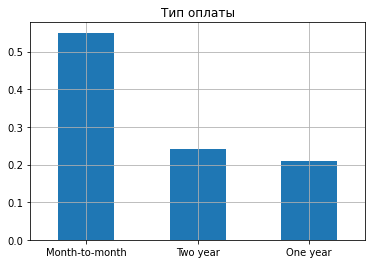

In [19]:
frequens(contract['type'], 0, 'Тип оплаты')

Тип оплаты: 

* 'Month-to-month' — каждый месяц, доля — 55.02%;
* 'Two year' — раз в два года, доля — 24.07%;
* 'One year' — раз в год, доля — 20.91%.

In [20]:
contract['paperless_billing'].unique()

array(['Yes', 'No'], dtype=object)

Yes    0.5922
No     0.4078
Name: paperless_billing, dtype: float64


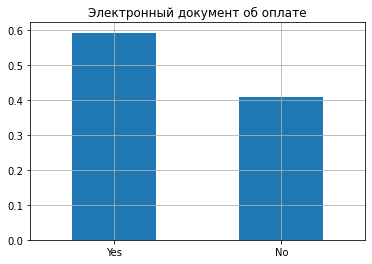

In [21]:
frequens(contract['paperless_billing'], 0, 
    'Электронный документ об оплате')

'paperless_billing' — электронный документ об оплате. Соответственно: 'Yes', 'No'. Доля 'Yes' — 59.22%.

In [22]:
contract['payment_method'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

Electronic check             0.3358
Mailed check                 0.2289
Bank transfer (automatic)    0.2192
Credit card (automatic)      0.2161
Name: payment_method, dtype: float64


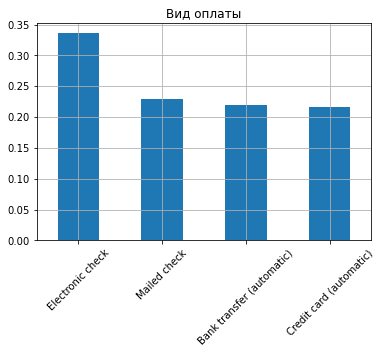

In [23]:
frequens(contract['payment_method'], 45, 'Вид оплаты')

Вид оплаты:

* 'Electronic check' — электронная оплата, доля — 33.58%;
* 'Mailed check' — оплата почтой, доля — 22.89%;
* 'Bank transfer (automatic)' — банквоский перевод автоматически со счета, доля — 21.92%;
* 'Credit card (automatic)' — автоматическое списание с кредитной карты, доля — 21.61%.

In [24]:
contract['monthly_charges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

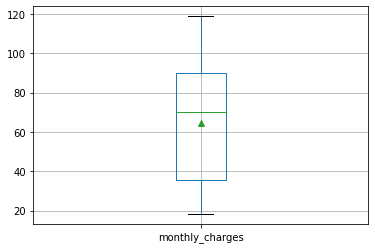

In [25]:
contract.boxplot(column='monthly_charges', showmeans=True);

Данные 'monthly_charges' без аномалий. Распределение с небольшим скосом вправо.

In [26]:
try:
    contract['total_charges'] =  pd.to_numeric(contract['total_charges'])
except (ValueError, TypeError) as vt:
    print("Ошибка: \n", vt)

Ошибка: 
 Unable to parse string " " at position 488


При попытке перевести значения в числовые вылезла ошибка.

In [27]:
contract.iloc[488]

customer_id                         4472-LVYGI
begin_date                 2020-02-01 00:00:00
end_date                                    No
type                                  Two year
paperless_billing                          Yes
payment_method       Bank transfer (automatic)
monthly_charges                          52.55
total_charges                                 
Name: 488, dtype: object

Заполним нулями, где дата создания договора 2020-02-01.

In [28]:
contract.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


In [29]:
contract.query('begin_date == "2020-02-01"')['total_charges'].unique()

array([' '], dtype=object)

In [30]:
for i in \
    contract.query('begin_date == "2020-02-01"')['total_charges'].index:
    contract.loc[i, 'total_charges'] = '0'

contract.query('begin_date == "2020-02-01"')['total_charges'].unique()

array(['0'], dtype=object)

In [31]:
contract['total_charges'] =  pd.to_numeric(contract['total_charges'])

In [32]:
contract['total_charges'].describe()

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: total_charges, dtype: float64

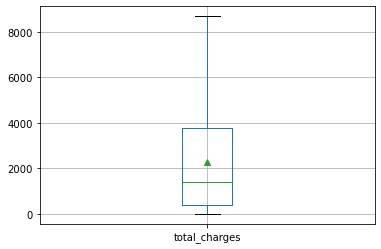

In [33]:
contract.boxplot(column='total_charges', showmeans=True);

Данные 'total_charges' без аномалий со скосом влево.

**Выводы `contract.csv`:**

* **customer_id**: уникальный код клиента;
* **begin_date**: дата заключения договора;
* **end_date**: дата прерывания договора;
* **type**: тип оплаты:
    * 'Month-to-month' — каждый месяц, доля — 55.02%;
    * 'Two year' — раз в два года, доля — 24.07%;
    * 'One year' — раз в год, доля — 20.91%.
* **paperless_billing**: электронный документ об оплате. Соответственно: 'Yes', 'No'. 
    * Доля 'Yes' — 59.22%;
* **payment_method**: вид оплаты:
    * 'Electronic check' — электронная оплата, доля — 33.58%;
    * 'Mailed check' — оплата почтой, доля — 22.89%;
    * 'Bank transfer (automatic)' — банквоский перевод автоматически со счета, доля — 21.92%;
    * 'Credit card (automatic)' — автоматическое списание с кредитной карты, доля — 21.61%.
* **monthly_charges**: ежемесячная плата;
    * Данные без аномалий; 
    * Распределение с небольшим скосом вправо;
* **total_charges**: общая сумма выплат;
    * Данные без аномалий; 
    * Распределение с небольшим скосом влево;

* Пропусков нет;
* Всего 7043 записи, все id клиента уникальны;
* Данные с 2013-10-01 по 2020-02-01;
* Даты заключения договора с 2013 по 2020, разница только в месяце, исчисление идет с 1 числа;
* Даты окончания договора все рядом: с 2019 года месяцы 10, 11 и 12; и 1 месяц 2020 года. В количестве суммарно 1869, что составляет 26,54% от всех записей. Месяцы:

    * 2019-10: 458 записей;
    * 2019-11: 485 записей;
    * 2019-12: 466 записей;
    * 2020-01: 460 записей;

* Договоры, созданные 2020-02-01, имеют нулевую общую сумму выплат.

### personal.csv

`personal.csv` — персональные данные клиента.

In [34]:
personal.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


Пойдем по такому же порядку исследования.

In [35]:
personal.columns = camel_to_snake(personal)
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Пропусков нет.

In [36]:
personal['customer_id'].nunique()

7043

Все записи 'customer_id' уникальны.

In [37]:
# Проверка на дубликаты

personal.duplicated().mean()

0.0

Дубликатов нет.

In [38]:
personal['gender'].unique()

array(['Female', 'Male'], dtype=object)

Male      0.5048
Female    0.4952
Name: gender, dtype: float64


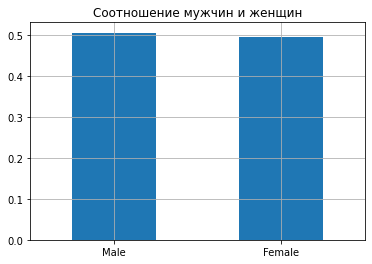

In [39]:
frequens(personal['gender'], 0, 'Cоотношение мужчин и женщин')

50/50 соотношение мужчин и женщин.

In [40]:
personal['senior_citizen'].sort_values().unique()

array([0, 1], dtype=int64)

0    0.8379
1    0.1621
Name: senior_citizen, dtype: float64


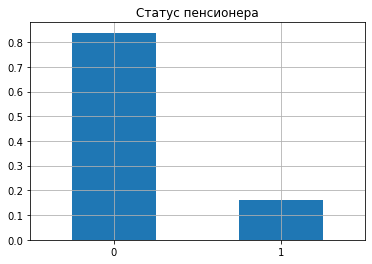

In [41]:
frequens(personal['senior_citizen'], 0, 'Статус пенсионера')

Пенсионер клиент или нет. Пенсионеров 16.21%.

In [42]:
personal['partner'].sort_values().unique()

array(['No', 'Yes'], dtype=object)

No     0.517
Yes    0.483
Name: partner, dtype: float64


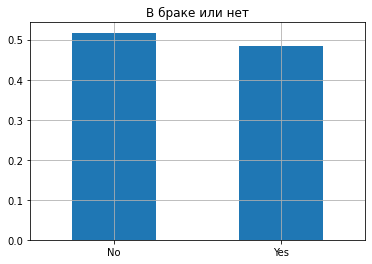

In [43]:
frequens(personal['partner'], 0, 'В браке или нет')

Примерно поровну клиентов в зарегистрированном браке:

    * No     51.7%;
    * Yes    48.3%.

In [44]:
personal['dependents'].sort_values().unique()

array(['No', 'Yes'], dtype=object)

No     0.7004
Yes    0.2996
Name: dependents, dtype: float64


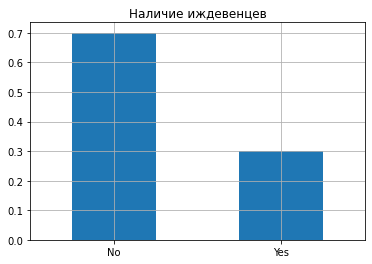

In [45]:
frequens(personal['dependents'], 0, 'Наличие иждевенцев')

Примерно 30% клиентов имеют иждевенцев.

**Выводы `personal.csv`:**

* **customer_id**: уникальный код клиента;
* Пропусков нет;
* Всего 7043 записей, все id клиента уникальны;
* **gender**: пол клиента, доли:
    * Male — 50.48%;
    * Female — 49.52%;
* **senior_citizen**: доля пенсионеров 16.21%;
* **partner**: доля, кто состоит в зарегистрированном браке:
    * No     51.7%;
    * Yes    48.3%.
* **dependents**: примерно 30% клиентов имеют иждевенцев;
* 'dependents' —  брак ли это зарегистрированный или просто партнер по жизни? На построение модели ответ на этот вопрос роли играть не будет.
* Аномалий нет.

### internet.csv

`internet.csv` — информация об интернет-услугах.

In [46]:
internet.head(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


In [47]:
internet.columns = camel_to_snake(internet)
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропусков нет.

In [48]:
internet['customer_id'].nunique()

5517

Все записи 'customer_id' уникальны.

In [49]:
# Проверка на дубликаты

internet.duplicated().mean()

0.0

Дубликатов нет.

In [50]:
internet['internet_service'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

Fiber optic    0.5612
DSL            0.4388
Name: internet_service, dtype: float64


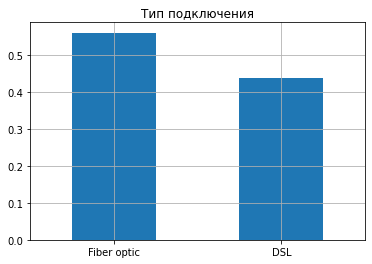

In [51]:
frequens(internet['internet_service'], 0, 'Тип подключения')

Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*). 
Доли:

* Fiber optic: 0.5612;
* DSL: 0.4388.

No     0.634
Yes    0.366
Name: online_security, dtype: float64


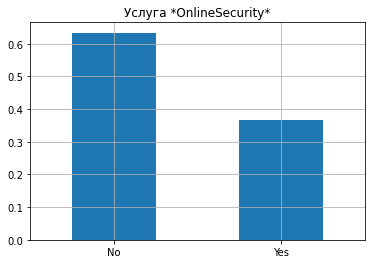

In [52]:
frequens(internet['online_security'], 0, 'Услуга *OnlineSecurity*')

Доля услуги "Блокировка небезопасных сайтов" (*OnlineSecurity*) — доля 36.6%.

No     0.5597
Yes    0.4403
Name: online_backup, dtype: float64


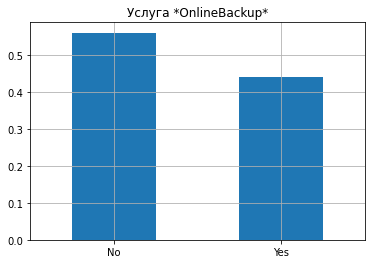

In [53]:
frequens(internet['online_backup'], 0, 'Услуга *OnlineBackup*')

Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*) — доля услуги 44.03%.

No     0.561
Yes    0.439
Name: device_protection, dtype: float64


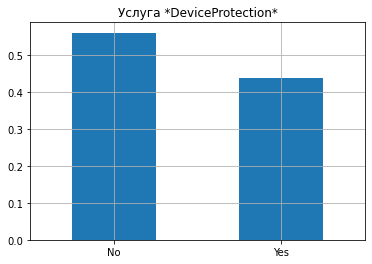

In [54]:
frequens(internet['device_protection'], 0, 'Услуга *DeviceProtection*')

Антивирус (*DeviceProtection*) — доля услуги 43.9%.

No     0.6295
Yes    0.3705
Name: tech_support, dtype: float64


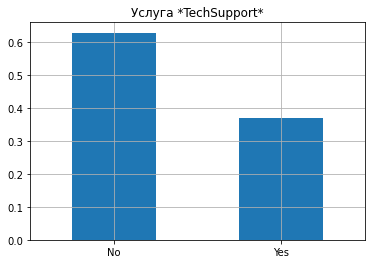

In [55]:
frequens(internet['tech_support'], 0, 'Услуга *TechSupport*')

Выделенная линия технической поддержки (*TechSupport*) — доля услуги 37.05%.

No     0.5093
Yes    0.4907
Name: streaming_tv, dtype: float64


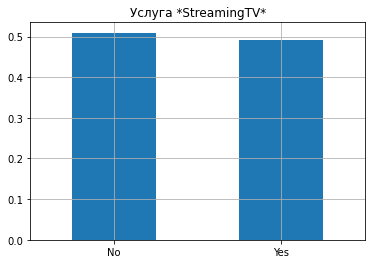

In [56]:
frequens(internet['streaming_tv'], 0, 'Услуга *StreamingTV*')

Стриминговое телевидение (*StreamingTV*) — доля услуги 49.07%.

No     0.5048
Yes    0.4952
Name: streaming_movies, dtype: float64


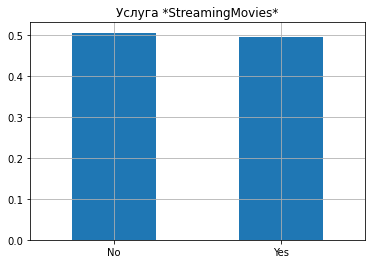

In [57]:
frequens(internet['streaming_movies'], 0, 'Услуга *StreamingMovies*')

Каталог фильмов (*StreamingMovies*) — доля услуги 49.52%.

**Выводы `internet.csv`:**

* **customer_id**: уникальный код клиента;
* Пропусков нет;
* Всего 5517 записей, все id клиента уникальны;
* **internet_service**: тип подключения:
    * Fiber optic: доля 56.12%;
    * DSL: доля 43.88%;
* **online_security**: услуга "Блокировка небезопасных сайтов" — доля 36.6%;
* **online_backup**: услуга "Облачное хранилище файлов для резервного копирования данных"  — доля 44.03%;
* **device_protection**: услуга "Антивирус"  — доля 43.9%;
* **tech_support**: услуга "Выделенная линия технической поддержки" — доля 37.05%;
* **streaming_tv**: услуга "Стриминговое телевидение" — доля 49.07%;
* **streaming_movies**: услуга "Каталог фильмов" — доля 49.52%;
* Аномалий нет.

### phone.csv

`phone.csv` — информация об услугах телефонии.

In [58]:
phone.head(3)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


In [59]:
phone.columns = camel_to_snake(phone)
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Пропусков нет.

In [60]:
phone['customer_id'].nunique()

6361

Все записи 'customer_id' уникальны.

In [61]:
# Проверка на дубликаты

phone.duplicated().mean()

0.0

Дубликатов нет.

No     0.5329
Yes    0.4671
Name: multiple_lines, dtype: float64


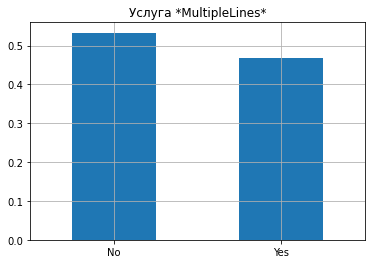

In [62]:
frequens(phone['multiple_lines'], 0, 'Услуга *MultipleLines*')

**Выводы `phone.csv`:**

* **customer_id**: уникальный код клиента;
* Пропусков нет;
* Всего 6361 записей, все id клиента уникальны;
* **multiple_lines**: услуга "Подключение телефонного аппарата к нескольким линиям одновременно":
    * Доля — 46.71%;
* Аномалий нет.

### Общий вывод

**Выводы `contract.csv`:**

* **customer_id**: уникальный код клиента;
* **begin_date**: дата заключения договора;
* **end_date**: дата прерывания договора;
* **type**: тип оплаты:
    * 'Month-to-month' — каждый месяц, доля — 55.02%;
    * 'Two year' — раз в два года, доля — 24.07%;
    * 'One year' — раз в год, доля — 20.91%.
* **paperless_billing**: электронный документ об оплате. Соответственно: 'Yes', 'No'. 
    * Доля 'Yes' — 59.22%;
* **payment_method**: вид оплаты:
    * 'Electronic check' — электронная оплата, доля — 33.58%;
    * 'Mailed check' — оплата почтой, доля — 22.89%;
    * 'Bank transfer (automatic)' — банквоский перевод автоматически со счета, доля — 21.92%;
    * 'Credit card (automatic)' — автоматическое списание с кредитной карты, доля — 21.61%.
* **monthly_charges**: ежемесячная плата;
    * Данные без аномалий; 
    * Распределение с небольшим скосом вправо;
* **total_charges**: общая сумма выплат;
    * Данные без аномалий; 
    * Распределение с небольшим скосом влево;

* Пропусков нет;
* Всего 7043 записи, все id клиента уникальны;
* Данные с 2013-10-01 по 2020-02-01;
* Даты заключения договора с 2013 по 2020, разница только в месяце, исчисление идет с 1 числа;
* Даты окончания договора все рядом: с 2019 года месяцы 10, 11 и 12; и 1 месяц 2020 года. В количестве суммарно 1869, что составляет 26,54% от всех записей. Месяцы:

    * 2019-10: 458 записей;
    * 2019-11: 485 записей;
    * 2019-12: 466 записей;
    * 2020-01: 460 записей;

* Договоры, созданные 2020-02-01, имеют нулевую общую сумму выплат.

**Выводы `personal.csv`:**

* **customer_id**: уникальный код клиента;
* Пропусков нет;
* Всего 7043 записей, все id клиента уникальны;
* **gender**: пол клиента, доли:
    * Male — 50.48%;
    * Female — 49.52%;
* **senior_citizen**: доля пенсионеров 16.21%;
* **partner**: доля, кто состоит в зарегистрированном браке:
    * No     51.7%;
    * Yes    48.3%.
* **dependents**: примерно 30% клиентов имеют иждевенцев;
* 'dependents' —  брак ли это зарегистрированный или просто партнер по жизни? На построение модели ответ на этот вопрос роли играть не будет.
* Аномалий нет.

**Выводы `internet.csv`:**

* **customer_id**: уникальный код клиента;
* Пропусков нет;
* Всего 5517 записей, все id клиента уникальны;
* **internet_service**: тип подключения:
    * Fiber optic: доля 56.12%;
    * DSL: доля 43.88%;
* **online_security**: услуга "Блокировка небезопасных сайтов" — доля 36.6%;
* **online_backup**: услуга "Облачное хранилище файлов для резервного копирования данных"  — доля 44.03%;
* **device_protection**: услуга "Антивирус"  — доля 43.9%;
* **tech_support**: услуга "Выделенная линия технической поддержки" — доля 37.05%;
* **streaming_tv**: услуга "Стриминговое телевидение" — доля 49.07%;
* **streaming_movies**: услуга "Каталог фильмов" — доля 49.52%;
* Аномалий нет.

**Выводы `phone.csv`:**

* **customer_id**: уникальный код клиента;
* Пропусков нет;
* Всего 6361 записей, все id клиента уникальны;
* **multiple_lines**: услуга "Подключение телефонного аппарата к нескольким линиям одновременно":
    * Доля — 46.71%;
* Аномалий нет.

## План работы

0. Объеденить таблицы по `customer_id`;
0. Обработать признаки, например:
    * "дата окончания договора" будет служить для модели классификации, будет целевым признаком;
    * Посмотреть, где образовались пропуски после объединения, обработать их;
    * Добавить признак: срок жизни договора клиента;
0. Сделать дополнительную предобработку, исследование;
0. Построить модели `CatBoost` и `sklearn.ensemble.RandomForestClassifier`.

## Подготовка выборки

In [63]:
contract.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


### Объединение и пропуски

Объеденим таблицы по `customer_id`.

In [64]:
telecom = contract.merge(internet, how='outer')
telecom = telecom.merge(phone, how='outer')
telecom = telecom.merge(personal, how='outer')
telecom.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,partner,dependents
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No,Male,0,No,No


Теперь будем разбираться с `NaN`. Начнем со столбцами из `internet`.

In [65]:
internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [66]:
telecom['internet_service'].isna().mean()

0.21666903308249325

21.6% пропущенных значений. Посмотрим, быть может это клиенты пользующиеся только телефонной связью.

In [67]:
telecom[telecom['internet_service'].isna() != False]\
    ['multiple_lines'].unique()

array(['No', 'Yes'], dtype=object)

`phone` содержит идентификаторы клиентов, кто пользуется телефонной стационарной связью и где указано только наличие дополнительной услуги *MultipleLines*. Значит можно заключить, что появившиеся `NaN` значения, означают, что пользователи используют только телефонную связь и не пользуются интернетом. Проверим гипотезу.

In [68]:
telecom[telecom['internet_service'].isna() != False].head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,partner,dependents
11,7469-LKBCI,2018-10-01,No,Two year,No,Credit card (automatic),18.95,326.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Male,0,No,No
16,8191-XWSZG,2015-10-01,No,One year,No,Mailed check,20.65,1022.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Female,0,No,No
21,1680-VDCWW,2019-02-01,No,One year,No,Bank transfer (automatic),19.80,202.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Male,0,Yes,No


Видим пропуски в услугах интернета. Проверим по всем данным.

In [69]:
telecom[telecom['internet_service'].isna() != False].isna().mean()

customer_id          0.0
begin_date           0.0
end_date             0.0
type                 0.0
paperless_billing    0.0
payment_method       0.0
monthly_charges      0.0
total_charges        0.0
internet_service     1.0
online_security      1.0
online_backup        1.0
device_protection    1.0
tech_support         1.0
streaming_tv         1.0
streaming_movies     1.0
multiple_lines       0.0
gender               0.0
senior_citizen       0.0
partner              0.0
dependents           0.0
dtype: float64

Что мы и наблюдаем: интернет услуги имеют везде пропуски в 100% строк. Клиент не пользуется интернетом, но пользуется услугами связи. Заполним пропуски значением `No`.

In [70]:
telecom[telecom['internet_service'].isna() != False] = \
telecom[telecom['internet_service'].isna() != False].fillna('No')

In [71]:
telecom.isna().mean()

customer_id          0.000000
begin_date           0.000000
end_date             0.000000
type                 0.000000
paperless_billing    0.000000
payment_method       0.000000
monthly_charges      0.000000
total_charges        0.000000
internet_service     0.000000
online_security      0.000000
online_backup        0.000000
device_protection    0.000000
tech_support         0.000000
streaming_tv         0.000000
streaming_movies     0.000000
multiple_lines       0.096834
gender               0.000000
senior_citizen       0.000000
partner              0.000000
dependents           0.000000
dtype: float64

Пропуски заполнили, остались значения в `multiple_lines`. Исследуем.

In [72]:
telecom[telecom['multiple_lines'].isna() != False].head(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,partner,dependents
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN,Female,0,Yes,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN,Male,0,No,No
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,DSL,Yes,No,No,No,No,No,NaN,Female,0,No,No
20,8779-QRDMV,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,39.65,39.65,DSL,No,No,Yes,No,No,Yes,NaN,Male,1,No,No
27,8665-UTDHZ,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Electronic check,30.20,30.20,DSL,No,Yes,No,No,No,No,NaN,Male,0,Yes,Yes


Видим, что `internet_service` не имеет значений `No`.

In [73]:
telecom[telecom['multiple_lines'].isna() != False]['internet_service'].unique()

array(['DSL'], dtype=object)

Поскольку у этих значений нет пропусков в столбце `internet_service` и получается нет данных о том, что это `multiple_lines`, можно заключить:

* Пользователи не используют `multiple_lines`, но являются возможными пользователями простой телефонной линии помимо интернета.
* Можно заполнить пропуски значением `No`.
* Следует добавить новый признак — использование телефонной связи одной линии, что для модели будет более полным описанием пользователя.
* Новый признак выявит клиентов кто пользуется интернетом и простой телефонной связью и не пользуется услугой `multiple_lines`.

Чтобы не отличаться в данных, заполним новый признак аналогично остальным: `Yes` и `No`.

Заполним пропуски в `multiple_lines`.

In [74]:
telecom['multiple_lines'].isna().mean()

0.09683373562402385

In [75]:
telecom['multiple_lines'] = telecom['multiple_lines'].fillna('No')
telecom['multiple_lines'].isna().mean()

0.0

In [76]:
telecom.isna().mean().mean()

0.0

Пропуски заполнили, теперь добавим новый признак.

In [77]:
len(telecom[telecom['customer_id'].isin(phone['customer_id']) != False])

6361

In [78]:
len(phone)

6361

In [79]:
telecom.loc[
    (telecom['customer_id'].isin(phone['customer_id']) != False), 
    'one_line'] = 'Yes'
telecom.isna().mean()

customer_id          0.000000
begin_date           0.000000
end_date             0.000000
type                 0.000000
paperless_billing    0.000000
payment_method       0.000000
monthly_charges      0.000000
total_charges        0.000000
internet_service     0.000000
online_security      0.000000
online_backup        0.000000
device_protection    0.000000
tech_support         0.000000
streaming_tv         0.000000
streaming_movies     0.000000
multiple_lines       0.000000
gender               0.000000
senior_citizen       0.000000
partner              0.000000
dependents           0.000000
one_line             0.096834
dtype: float64

Остается оставшееся заполнить значениями `No`, поскольку добавляли по идентификаторам из `phone`.

In [80]:
telecom['one_line'] = telecom['one_line'].fillna('No')
telecom['one_line'].unique()

array(['No', 'Yes'], dtype=object)

In [81]:
telecom.isna().mean().mean()

0.0

Можно посчитать, что этот признак будет лишним, однако:

* Раз клиент не пользуется многоканальной телефонной линией, то он пользуется просто телефонной связью.

In [82]:
telecom[telecom['multiple_lines'] == 'No']['one_line'].unique()

array(['No', 'Yes'], dtype=object)

Однако мы видим, что и пользуется и не пользуется. А что с интернетом?

In [83]:
telecom[telecom['multiple_lines'] == 'No'].query('one_line == "Yes"')\
    ['internet_service'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

Как мы видим, наш новый признак разделил и выявил клиентов, кто:

* Не пользуется многоканальной связью;
* Пользуется телефонной связью;
* И при этом может пользоваться интернетом, а может и не пользоваться.

Отсюда вывод:

* Если бы мы не добавили новый признак, то мы бы считали, что раз клиент не пользуется многоканальной связью, то значит он пользуется только интернетом, а связью простой не пользуется. Однако это не так.
* И у нас бы было, что клиент не пользуется многоканальной связью и не пользуется интернетом. Тогда чем он пользуется и почему он клиент?

* Все это верно, поскольку `one_line == "Yes"` мы добавили из `phone`. Где если, если есть клиент, значит и есть договор; и если есть договор и `'multiple_lines' == 'No'`, то значит пользуется простой связью.

Значит должно быть и верно следующее:

* Клиент имеет `'multiple_lines' == 'No'`, также `one_line == "No"`, значит обязательно должен пользоваться интернетом. Иначе на чем основан его контракт/договор? Проверим.

In [84]:
telecom[telecom['multiple_lines'] == 'No'].query('one_line == "No"')\
    ['internet_service'].unique()

array(['DSL'], dtype=object)

Все сошлось. Значит можно считать наше мышление разумным. Для еще проверки можно оставить следующие строчки кода.

In [85]:
telecom[telecom['multiple_lines'] == 'Yes']['one_line'].unique()

array(['Yes'], dtype=object)

In [86]:
telecom[telecom['multiple_lines'] == 'No'].query('internet_service == "No"')\
    ['one_line'].unique()

array(['Yes'], dtype=object)

Все сошлось.

### Обработка признаков с датами

In [87]:
telecom.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,partner,dependents,one_line
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,No,No,Female,0,Yes,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,Yes,No,No,No,No,Male,0,No,No,Yes
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,No,No,Male,0,No,No,Yes


In [88]:
telecom['end_date'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

`No` превратим в `NaN` и далее изменим тип данных на `datetime`.

In [89]:
telecom.loc[(telecom['end_date'] == 'No'), 'end_date'] = np.nan

telecom['end_date'] = pd.to_datetime(
    telecom['end_date'], format='%Y.%m.%d %H:%M:%S')

telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   internet_service   7043 non-null   object        
 9   online_security    7043 non-null   object        
 10  online_backup      7043 non-null   object        
 11  device_protection  7043 non-null   object        
 12  tech_support       7043 non-null   object        
 13  streaming_tv       7043 non-null   object        
 14  streamin

Добавим новый признак: срок жизни договора клиента.

In [90]:
telecom['lifetime_contract'] = telecom['end_date'] - telecom['begin_date']
telecom['lifetime_contract'].head(3)

0       NaT
1       NaT
2   61 days
Name: lifetime_contract, dtype: timedelta64[ns]

In [91]:
telecom.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,partner,dependents,one_line,lifetime_contract
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,No,Female,0,Yes,No,No,NaT
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,No,No,No,No,Male,0,No,No,Yes,NaT
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,No,Male,0,No,No,Yes,61 days


Изменим тип данных на `float64`.

In [92]:
telecom['lifetime_contract'] = \
    pd.TimedeltaIndex(telecom['lifetime_contract']).days

telecom['lifetime_contract'].dtypes

dtype('float64')

Сразу изучим получившиеся данные.

In [93]:
telecom['lifetime_contract'].describe()

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: lifetime_contract, dtype: float64

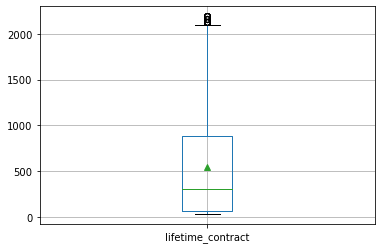

In [94]:
telecom.boxplot(column='lifetime_contract', showmeans=True);

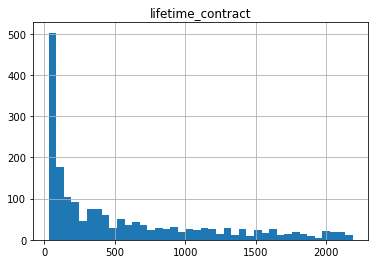

In [95]:
telecom.hist('lifetime_contract', bins=40);

Дополнительно вычислим процент уходящих в 1 месяц.

In [96]:
(len(telecom[telecom['lifetime_contract'] < 32]['lifetime_contract'])
     / telecom['lifetime_contract'].describe()[0]).round(4)

0.2033

О чем нам говорят данные об ушедших клиентах, что бросается в глаза:

* Распределение значений — со скосом влево.
* Медиана 304 дня.
* Среднее 594 дня.
* Половина клиентов уходит в первый год.
* Ровно четверть из ушедших ушли в первые два месяца.
* 20.33% ушли в первый месяц.

Заполним оставшиеся значения `NaN` в `lifetime_contract`.

In [97]:
telecom.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,partner,dependents,one_line,lifetime_contract
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,No,Female,0,Yes,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,No,No,No,No,Male,0,No,No,Yes,NaN
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,No,Male,0,No,No,Yes,61.0


In [98]:
telecom['begin_date'].describe(datetime_is_numeric=True)

count                             7043
mean     2017-04-30 13:01:50.918642688
min                2013-10-01 00:00:00
25%                2015-06-01 00:00:00
50%                2017-09-01 00:00:00
75%                2019-04-01 00:00:00
max                2020-02-01 00:00:00
Name: begin_date, dtype: object

* Создадим сначала target признак, чтобы столбец `end_date` больше нам не нужен был.
* Заполним пропуски `end_date` датой выгрузки данных 2020-02-01 00:00:00.
* Заново создадим `lifetime_contract` уже со всеми клиентами.

In [99]:
telecom['term_contract'] = (telecom['end_date'].isna() == False)*1
telecom.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,partner,dependents,one_line,lifetime_contract,term_contract
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,Female,0,Yes,No,No,NaN,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,No,No,No,Male,0,No,No,Yes,NaN,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,Male,0,No,No,Yes,61.0,1


* Заполним пропуски `end_date` последней датой 2020-02-01 00:00:00.

In [100]:
telecom['end_date'] = telecom['end_date'].fillna(pd.Timestamp('2020-02-01 00:00:00'))

telecom['end_date'].head(3)

0   2020-02-01
1   2020-02-01
2   2019-12-01
Name: end_date, dtype: datetime64[ns]

* Заного создадим `lifetime_contract` уже со всеми клиентами.

In [101]:
telecom['lifetime_contract'] = telecom['begin_date'] - telecom['end_date']
telecom['lifetime_contract'] = \
    abs(pd.TimedeltaIndex(telecom['lifetime_contract']).days)

telecom['lifetime_contract'].dtypes

dtype('int64')

In [102]:
telecom.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,partner,dependents,one_line,lifetime_contract,term_contract
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,Female,0,Yes,No,No,31,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,No,No,No,Male,0,No,No,Yes,1036,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,Male,0,No,No,Yes,61,1


Удалим столбцы 	`begin_date` и `end_date`. Также `customer_id` для модели будет не нужен.

In [103]:
telecom = telecom.drop(
    labels=['begin_date', 'end_date', 'customer_id'], axis=1)
telecom.head(3)

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,partner,dependents,one_line,lifetime_contract,term_contract
0,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,No,Female,0,Yes,No,No,31,0
1,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No,Male,0,No,No,Yes,1036,0
2,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No,Male,0,No,No,Yes,61,1


In [104]:
telecom.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines', 'gender', 'senior_citizen', 'partner', 'dependents',
       'one_line', 'lifetime_contract', 'term_contract'],
      dtype='object')

Все преобразования прошли успешно.

**Вывод:**

* Объеденили 4 таблицы.
* После обработали пропуски, где интернет и его услуги имели `NaN`:
    * Интернет услуги имели везде пропуски в 100% строк, где клиент не пользуется интернетом, но пользуется услугами связи. Заполнили пропуски значением `No`.

* После оставшиеся единственные пропуски в `multiple_lines` значением `No`, поскольку слияние происходило по `phone`.

* Добавили признак `one_line`, выявивший  клиентов:
    * Кто не пользуется многоканальной связью, пользуется интернетом и пользуется простой связью.
    * Также выявлена прозрачность, если клиент не пользуется многоканальной связью и не пользуется интернетом, то на чем основан его контракт/договор (?) — на простой связи.
    * Эту гипотезу проверили.

* Исследовали срок жизни договора клиентов, кто расторгнул этот договор:

    * Распределение значений — со скосом влево.
    * Медиана 304 дня.
    * Среднее 594 дня.
    * Половина клиентов уходит в первый год.
    * Ровно четверть из ушедших ушли в первые два месяца.
    * 14.67% ушли через 2000 дней (5.5 лет).
    * 20.33% ушли в первый месяц.

* Добавили новый признак `lifetime_contract`, означающий срок жизни клиентов.
* Добавили новый признак `term_contract`, означающий уход клиента (целевой признак для моделей).

## Построение моделей

Будем использовать:

*  `sklearn.ensemble.RandomForestClassifier`
* `CatBoost`

In [105]:
telecom.head(3)

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,partner,dependents,one_line,lifetime_contract,term_contract
0,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,No,Female,0,Yes,No,No,31,0
1,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No,Male,0,No,No,Yes,1036,0
2,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No,Male,0,No,No,Yes,61,1


### Предобработка данных

Поделим `telecom` на `train` и `test`.

In [106]:
X_train, X_test, y_train, y_test = train_test_split(
    telecom.drop('term_contract', axis=1), 
    telecom['term_contract'], 
    test_size=0.25, random_state=290822)

print('Получившиеся выборки:')
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

Получившиеся выборки:
X_train:  (5282, 19)
y_train:  (5282,)
X_test:  (1761, 19)
y_test:  (1761,)


* Большинство признаков имеют категориальные и имеют свою вариативность от еденицы до 4. Можно вручную не переделывать, а применить `OneHotEncoder`.

In [107]:
cat_f = X_train.columns.drop(['monthly_charges', 
'total_charges', 'senior_citizen', 'lifetime_contract'])

enc = OneHotEncoder(drop='first', sparse=False).fit(X_train[cat_f])

X_train.loc[:, enc.get_feature_names_out()] = enc.transform(X_train[cat_f])
X_test.loc[:, enc.get_feature_names_out()] = enc.transform(X_test[cat_f])

X_train = X_train.drop(columns=cat_f, axis=1)
X_test = X_test.drop(columns=cat_f, axis=1)

print('Получившиеся выборки после OneHotEncoder:')
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

Получившиеся выборки после OneHotEncoder:
X_train:  (5282, 23)
y_train:  (5282,)
X_test:  (1761, 23)
y_test:  (1761,)


Взглянем на балансы классов.

0    0.7361
1    0.2639
Name: term_contract, dtype: float64


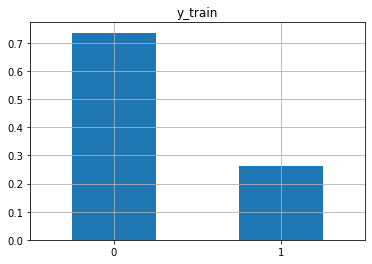

In [108]:
frequens(y_train, 0, 'y_train')

0    0.7303
1    0.2697
Name: term_contract, dtype: float64


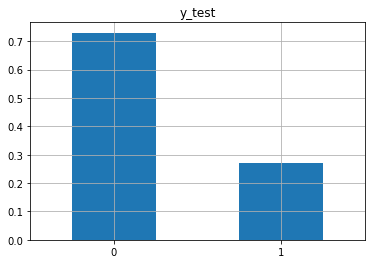

In [109]:
frequens(y_test, 0, 'y_test')

Сделаем константное предсказание.

In [110]:
y_constant = pd.Series([0] * len(y_train), index=y_train.index)

roc_auc_const = roc_auc_score(y_train, y_constant)
acc_const = accuracy_score(y_train, y_constant).round(3)
f1_const = f1_score(y_train, y_constant)

print('Константное предсказание ROC_AUC: ', roc_auc_const)
print('Константное предсказание Accuracy: ', acc_const)
print('Константное предсказание F1_score: ', f1_const)

Константное предсказание ROC_AUC:  0.5
Константное предсказание Accuracy:  0.736
Константное предсказание F1_score:  0.0


Хорошо заметно преимущество `f1_score` перед `Accuracy`.

### Функции

In [111]:
def rfr_model(X_train, y_train, class_weight=None):

    name = 'RandomForestClassifier'

    model = RandomForestClassifier(
                random_state=290822,
                class_weight=class_weight,
                n_jobs=-1,
                criterion='log_loss'
            )

    grid = {'n_estimators': range(170, 231, 30),
            'max_depth': range(6, 13, 2),
            'min_samples_split': range(2, 7, 2),
            'min_samples_leaf': range(1, 4, 1)}

    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=290822)

    clf = GridSearchCV(model,
                    param_grid=grid,
                    scoring='roc_auc',
                    n_jobs=-1,
                    cv=cv,
                    )

    clf.fit(X_train, y_train)

    print('\n')
    print("Random Forest Classifier", '\n')

    best_rfr = clf.best_estimator_


    print("Лучший score на кросс валидации: ", 
                        round(clf.best_score_, 3))
    print('\n')
    display("Лучшие гиперпараметры: ", clf.best_params_)

    print('train предсказание ROC_AUC: ', 
    roc_auc_score(y_train, best_rfr.predict(X_train)).round(3),
    'const: ', roc_auc_const)

    print('train предсказание Accuracy: ', 
        accuracy_score(y_train, best_rfr.predict(X_train)).round(3),
    'const: ', acc_const)

    print('train предсказание F1_score: ', 
        f1_score(y_train, best_rfr.predict(X_train)).round(3),
    'const: ', f1_const)

    return

In [112]:
def cat_model(X_train, y_train, scale_pos_weight=1):

    name = 'CatBoost'

    cat_train = Pool(data=X_train, label=y_train)
    #cat_test = Pool(data=X_test, label=y_test)

    params = {'eval_metric': 'Logloss',
            'loss_function': 'Logloss',
            'random_seed': 290822,
            'iterations': 5000,
            'early_stopping_rounds': 200,
            'scale_pos_weight': scale_pos_weight,
            'verbose':False}

    model = CatBoost(params=params)

    grid = {'learning_rate': [0.1, 0.15, 0.18],
            'depth': range(1,5,1),
            'l2_leaf_reg': [1, 2, 3, 4]}

    cv = RepeatedKFold(n_splits=6, n_repeats=2, random_state=290822)

    grid_search_result = model.grid_search(grid, 
                                        X=X_train, 
                                        y=y_train, 
                                        cv=cv,
                                        partition_random_seed=290822,
                                        search_by_train_test_split=True,
                                        train_size=0.8,
                                        stratified=True,
                                        shuffle=True,
                                        verbose=False,
                                        refit=True)

    n_iter = np.argmin(grid_search_result['cv_results']['test-Logloss-mean'])

    print("Cat Boost", '\n')

    print("Лучший Logloss на кросс валидации: ", 
        round(grid_search_result['cv_results']['test-Logloss-mean'][n_iter], 3))

    display('Гиперпараметры лучшего результата', 
        grid_search_result['params'])

    print('iterations: ', n_iter, '\n')

    params = {'eval_metric': 'Logloss',
            'loss_function': 'Logloss',
            'learning_rate': grid_search_result['params']['learning_rate'],
            'depth': grid_search_result['params']['depth'],
            'random_seed': 290822,
            'l2_leaf_reg': grid_search_result['params']['l2_leaf_reg'],
            'random_strength': 290822,
            'scale_pos_weight': scale_pos_weight,
            'iterations': n_iter,
            'verbose':False}

    cat = CatBoostClassifier(**params)
    cat.fit(cat_train)

    (fpr, tpr, thresholds) = get_roc_curve(cat, cat_train)
    sum = tpr + (1-fpr)
    cat.set_probability_threshold(thresholds[np.argmax(sum)])

    print('thresholds: ', thresholds[np.argmax(sum)], '\n')

    print('train предсказание ROC_AUC: ', 
    roc_auc_score(y_train, cat.predict(cat_train)).round(3),
    'const: ', roc_auc_const)

    print('train предсказание Accuracy: ', 
        accuracy_score(y_train, cat.predict(cat_train)).round(3),
    'const: ', acc_const)

    print('train предсказание F1_score: ', 
        f1_score(y_train, cat.predict(cat_train)).round(3),
    'const: ', f1_const)

    return

### Исходный баланс классов

Взглянем балансы классов.

0    0.7361
1    0.2639
Name: term_contract, dtype: float64


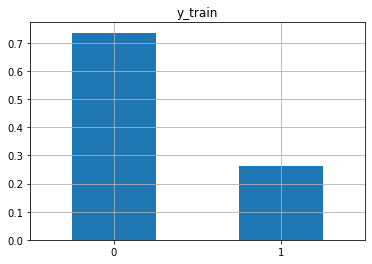

In [113]:
frequens(y_train, 0, 'y_train')

0    0.7303
1    0.2697
Name: term_contract, dtype: float64


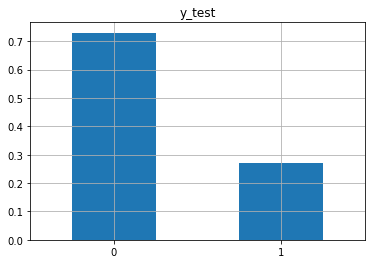

In [114]:
frequens(y_test, 0, 'y_test')

#### RandomForestClassifier

In [115]:
%%time

rfr_model(X_train, y_train)



Random Forest Classifier 

Лучший score на кросс валидации:  0.86




'Лучшие гиперпараметры: '

{'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 200}

train предсказание ROC_AUC:  0.755 const:  0.5
train предсказание Accuracy:  0.846 const:  0.736
train предсказание F1_score:  0.659 const:  0.0
CPU times: total: 6.7 s
Wall time: 2min 5s


#### CatBoost

In [116]:
%%time

cat_model(X_train, y_train)


bestTest = 0.3615035244
bestIteration = 4993


bestTest = 0.3575471462
bestIteration = 4992


bestTest = 0.3550741153
bestIteration = 4969


bestTest = 0.3614398629
bestIteration = 4998


bestTest = 0.3580257982
bestIteration = 4953


bestTest = 0.3552337857
bestIteration = 4996


bestTest = 0.3613735877
bestIteration = 4947


bestTest = 0.3573773303
bestIteration = 4932


bestTest = 0.3547759293
bestIteration = 4971


bestTest = 0.3613039599
bestIteration = 4981


bestTest = 0.3575342143
bestIteration = 4999


bestTest = 0.3546277973
bestIteration = 4969

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.334451932
bestIteration = 490

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3065894398
bestIteration = 1181

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3053403329
bestIteration = 1054

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3212656102
bestIteration = 1133

Stopped by overfitting detecto

'Гиперпараметры лучшего результата'

{'depth': 2, 'l2_leaf_reg': 1, 'learning_rate': 0.18}

iterations:  1442 

thresholds:  0.30807928051582556 

train предсказание ROC_AUC:  0.922 const:  0.5
train предсказание Accuracy:  0.926 const:  0.736
train предсказание F1_score:  0.868 const:  0.0
CPU times: total: 29min 5s
Wall time: 3min 10s


### Встроенные методы

#### RandomForestClassifier

In [117]:
%%time

rfr_model(X_train, y_train, 'balanced')



Random Forest Classifier 

Лучший score на кросс валидации:  0.859




'Лучшие гиперпараметры: '

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 170}

train предсказание ROC_AUC:  0.866 const:  0.5
train предсказание Accuracy:  0.859 const:  0.736
train предсказание F1_score:  0.768 const:  0.0
CPU times: total: 7.78 s
Wall time: 2min 18s


#### CatBoost

In [118]:
%%time

cat_model(X_train, y_train, 2)


bestTest = 0.428375335
bestIteration = 4966


bestTest = 0.4239254236
bestIteration = 4971


bestTest = 0.4212822828
bestIteration = 4998


bestTest = 0.4286289756
bestIteration = 4999


bestTest = 0.4232118448
bestIteration = 4968


bestTest = 0.4207303428
bestIteration = 4964


bestTest = 0.4280971594
bestIteration = 4968


bestTest = 0.4233977344
bestIteration = 4994


bestTest = 0.4204400656
bestIteration = 4985


bestTest = 0.4286573947
bestIteration = 4997


bestTest = 0.4230632401
bestIteration = 4988


bestTest = 0.4212616762
bestIteration = 4977

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3677050188
bestIteration = 1562

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3617995451
bestIteration = 1110

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3635844347
bestIteration = 754

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3833582201
bestIteration = 1278

Stopped by overfitting detecto

'Гиперпараметры лучшего результата'

{'depth': 2, 'l2_leaf_reg': 1, 'learning_rate': 0.15}

iterations:  1475 

thresholds:  0.4463893747021972 

train предсказание ROC_AUC:  0.919 const:  0.5
train предсказание Accuracy:  0.919 const:  0.736
train предсказание F1_score:  0.857 const:  0.0
CPU times: total: 26min 56s
Wall time: 2min 51s


### downsampling

* Используем downsampling и проверим метрики

In [119]:
# downsampling функция
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=290822)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=290822)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=290822)
    
    return features_downsampled, target_downsampled

In [120]:
X_train_down, y_train_down = downsample(X_train, y_train, 0.36)

print('Получившиеся выборки:')
print('X_train_down: ', len(X_train_down))
print('y_train_down: ', len(y_train_down))

Получившиеся выборки:
X_train_down:  2794
y_train_down:  2794


0    0.5011
1    0.4989
Name: term_contract, dtype: float64


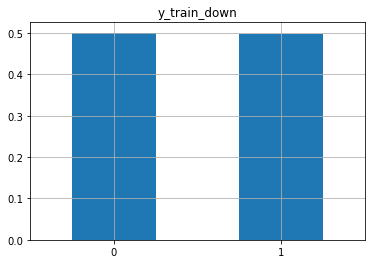

In [121]:
frequens(y_train_down, 0, 'y_train_down')

#### RandomForestClassifier

In [122]:
%%time

rfr_model(X_train_down, y_train_down)



Random Forest Classifier 

Лучший score на кросс валидации:  0.857




'Лучшие гиперпараметры: '

{'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 230}

train предсказание ROC_AUC:  0.834 const:  0.5
train предсказание Accuracy:  0.834 const:  0.736
train предсказание F1_score:  0.838 const:  0.0
CPU times: total: 4.53 s
Wall time: 1min 40s


#### CatBoost

In [123]:
%%time

cat_model(X_train_down, y_train_down)

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4297086023
bestIteration = 1874

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.425647361
bestIteration = 3191

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4274017901
bestIteration = 2095

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4299509355
bestIteration = 2181

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4278482558
bestIteration = 2301

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4264163399
bestIteration = 2221

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4264529753
bestIteration = 3693

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4261557008
bestIteration = 2872

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4254050223
bestIteration = 2010

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4280766845
bes

'Гиперпараметры лучшего результата'

{'depth': 2, 'l2_leaf_reg': 1, 'learning_rate': 0.15}

iterations:  1100 

thresholds:  0.49193121286773966 

train предсказание ROC_AUC:  0.919 const:  0.5
train предсказание Accuracy:  0.919 const:  0.736
train предсказание F1_score:  0.919 const:  0.0
CPU times: total: 15min 57s
Wall time: 1min 41s


### feature_importance

Воспользуемся методами моделей, чтобы изучить важность признаков в наших моделях.

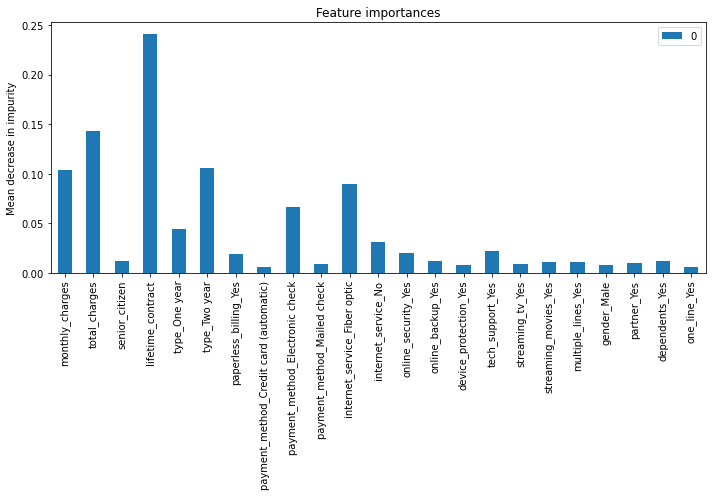

In [124]:
feature_names = X_train.columns 
model = RandomForestClassifier(n_estimators=200, 
                            random_state=290822,
                            criterion='log_loss',
                            max_depth=8,
                            min_samples_leaf=1,
                            min_samples_split=4)
model.fit(X_train, y_train)
pred = model.predict(X_test)
importances = model.feature_importances_
model_importances = pd.DataFrame(importances, index=feature_names)

std = np.std([model.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Выведем таблицей

In [125]:
rfr_imp = model_importances.sort_values(by=0, ascending=False)
rfr_imp

,0
lifetime_contract,0.240724
total_charges,0.143464
type_Two year,0.106125
monthly_charges,0.103900
internet_service_Fiber optic,0.089772
payment_method_Electronic check,0.066567
type_One year,0.044401
internet_service_No,0.030951
tech_support_Yes,0.022448
online_security_Yes,0.019583


Сделаем то же самое в `CatBoost`.

In [126]:
cat_train = Pool(data=X_train, label=y_train)
cat_test = Pool(data=X_test, label=y_test)

params = {'eval_metric': 'Logloss',
        'loss_function': 'Logloss',
        'learning_rate': 0.18,
        'depth': 2,
        'random_seed': 290822,
        'l2_leaf_reg': 1,
        'random_strength': 290822,
        'scale_pos_weight': 1,
        'iterations': 1442,
        'verbose':False}

cat = CatBoostClassifier(**params)
cat.fit(cat_train)

cat.set_probability_threshold(0.30807928051582556)

cat.get_feature_importance(data=cat_train,
                       prettified=True)

,Feature Id,Importances
0,lifetime_contract,74.537029
1,total_charges,6.882025
2,monthly_charges,6.626509
3,type_Two year,3.982592
4,internet_service_No,1.204864
5,type_One year,1.073254
6,internet_service_Fiber optic,0.821432
7,payment_method_Mailed check,0.629525
8,online_security_Yes,0.435371
9,tech_support_Yes,0.409615


Сравним.

In [127]:
cat.get_feature_importance(data=cat_train, prettified=True)\
            .merge(rfr_imp, left_on='Feature Id', right_index=True)

,Feature Id,Importances,0
0,lifetime_contract,74.537029,0.240724
1,total_charges,6.882025,0.143464
2,monthly_charges,6.626509,0.103900
3,type_Two year,3.982592,0.106125
4,internet_service_No,1.204864,0.030951
5,type_One year,1.073254,0.044401
6,internet_service_Fiber optic,0.821432,0.089772
7,payment_method_Mailed check,0.629525,0.009226
8,online_security_Yes,0.435371,0.019583
9,tech_support_Yes,0.409615,0.022448


В целом одинаково. Только `payment_method_Electronic check` у леса более важный признак, чем y буста.

Возьмем по 14 признак (более значимые по 2 моделям) и добавим `payment_method_Electronic check`. Обучим заново модели и посмотрим на метрики.

In [128]:
cat.get_feature_importance(data=cat_train,
                       prettified=True).iloc[14]['Feature Id']

'payment_method_Electronic check'

In [129]:
f_imp = cat.get_feature_importance(data=cat_train,
                       prettified=True).loc[:14, 'Feature Id'].to_list()

f_imp

['lifetime_contract',
 'total_charges',
 'monthly_charges',
 'type_Two year',
 'internet_service_No',
 'type_One year',
 'internet_service_Fiber optic',
 'payment_method_Mailed check',
 'online_security_Yes',
 'tech_support_Yes',
 'payment_method_Credit card (automatic)',
 'paperless_billing_Yes',
 'senior_citizen',
 'device_protection_Yes',
 'payment_method_Electronic check']

In [130]:
X_train_imp = X_train.loc[:, f_imp]
X_train_imp.shape

(5282, 15)

Обучим модели и посмотрим на результат.

In [131]:
%%time

rfr_model(X_train_imp, y_train)



Random Forest Classifier 

Лучший score на кросс валидации:  0.86




'Лучшие гиперпараметры: '

{'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

train предсказание ROC_AUC:  0.751 const:  0.5
train предсказание Accuracy:  0.84 const:  0.736
train предсказание F1_score:  0.65 const:  0.0
CPU times: total: 4.89 s
Wall time: 2min 12s


In [132]:
%%time

cat_model(X_train_imp, y_train)


bestTest = 0.3599226402
bestIteration = 4999


bestTest = 0.3557500995
bestIteration = 4997


bestTest = 0.3534421623
bestIteration = 4999


bestTest = 0.3600499054
bestIteration = 4994


bestTest = 0.3556340662
bestIteration = 4964


bestTest = 0.3538650962
bestIteration = 4993


bestTest = 0.3602792504
bestIteration = 4933


bestTest = 0.3556938657
bestIteration = 4989


bestTest = 0.3533501925
bestIteration = 4994


bestTest = 0.360556785
bestIteration = 4925


bestTest = 0.3558833457
bestIteration = 4986


bestTest = 0.3537120652
bestIteration = 4995

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3144997061
bestIteration = 1476

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3099381991
bestIteration = 1007

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3063928147
bestIteration = 718

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3105511606
bestIteration = 2311

Stopped by overfitting detecto

'Гиперпараметры лучшего результата'

{'depth': 2, 'l2_leaf_reg': 1, 'learning_rate': 0.18}

iterations:  1808 

thresholds:  0.27381419399180923 

train предсказание ROC_AUC:  0.926 const:  0.5
train предсказание Accuracy:  0.923 const:  0.736
train предсказание F1_score:  0.865 const:  0.0
CPU times: total: 30min 3s
Wall time: 3min 19s


### Вывод

* Разделили данные на `train` и `test` в соотношении 75/25.

* Для построение моделей использовали:

    *  `sklearn.ensemble.RandomForestClassifier`
    * `CatBoost`

* Большинство признаков имеют категориальные и имеют свою вариативность от еденицы до 4, поэтому для простоты предобработки применили `OneHotEncoder`.
* Масштабирование для наших моделей не требуется.
* Обнаружен небольшой дисбаланс классов:

    * 26.39% класса 1.

* Константное предсказание для оценок адекватности моделей (**const**):

    * Константное предсказание ROC_AUC:  0.5
    * Константное предсказание Accuracy:  0.736
    * Константное предсказание F1_score:  0.0

* В моделях для поиска лучших гиперпараметров будем использовать GridSearchCV, а также через AUG_ROG кривую подбирать лучший thresholds.

**Построение моделей без изменения баланса классов:**

* **RandomForestClassifier:**

    * Лучшие гиперпараметры:

        * 'max_depth': 8,
        * 'min_samples_leaf': 1,
        * 'min_samples_split': 4,
        * 'n_estimators': 200

    * train предсказание ROC_AUC:  0.755; const:  0.5
    * train предсказание Accuracy:  0.846; const:  0.736
    * train предсказание F1_score:  0.659; const:  0.0

* **CatBoost:**

    * Гиперпараметры лучшего результата
    
        * 'depth': 2, 
        * 'l2_leaf_reg': 1, 
        * 'learning_rate': 0.18
        * 'iterations': 1442
        * 'thresholds':  0.30807928051582556

    * train предсказание ROC_AUC:  0.922; const:  0.5
    * train предсказание Accuracy:  0.926; const:  0.736
    * train предсказание F1_score:  0.868; const:  0.0




**Построение моделей со встроенными методами:**

* **RandomForestClassifier с class_weight='balanced':**

    * Лучшие гиперпараметры:

        * 'max_depth': 10,
        * 'min_samples_leaf': 1,
        * 'min_samples_split': 6,
        * 'n_estimators': 170

    * train предсказание ROC_AUC:  0.866 const:  0.5
    * train предсказание Accuracy:  0.859 const:  0.736
    * train предсказание F1_score:  0.768 const:  0.0

* **CatBoost с scale_pos_weight=2:**

    * Гиперпараметры лучшего результата
    
        * 'depth': 2, 
        * 'l2_leaf_reg': 1, 
        * 'learning_rate': 0.15
        * 'iterations': 1475
        * 'thresholds':  0.4463893747021972

    * train предсказание ROC_AUC:  0.919; const:  0.5
    * train предсказание Accuracy:  0.919; const:  0.736
    * train предсказание F1_score:  0.857; const:  0.0




**Построение моделей с downsampling:**

* **RandomForestClassifier:**

    * Лучшие гиперпараметры:

        * 'max_depth': 8,
        * 'min_samples_leaf': 2,
        * 'min_samples_split': 6,
        * 'n_estimators': 230

    * train предсказание ROC_AUC:  0.834; const:  0.5
    * train предсказание Accuracy:  0.834; const:  0.736
    * train предсказание F1_score:  0.838; const:  0.0

* **CatBoost:**

    * Гиперпараметры лучшего результата
    
        * 'depth': 2, 
        * 'l2_leaf_reg': 1, 
        * 'learning_rate': 0.15
        * 'iterations': 1100
        * 'thresholds':  0.49193121286773966

    * train предсказание ROC_AUC:  0.919; const:  0.5
    * train предсказание Accuracy:  0.919; const:  0.736
    * train предсказание F1_score:  0.919; const:  0.0


* Изучили с помощью методов от `RandomForestClassifier` и `CatBoost` важность признаков в построении модели.
* Обе модели определили примерно одинаково признаки по важности.
* Если брать за 100% как суммарный фактор важности всех наших признаков, то топ 5 признаков, влияющие на уход клиента:

    * `lifetime_contract`: 74.537 %
    * `total_charges`: 6.882 %
    * `monthly_charges`: 6.626 %
    * `type_Two year`: 3.982 %
    * `internet_service_No`: 1.205 %

* Выбрали топ 15 и заново обучили модели, чтобы посмотреть как изменится результат.



**Построение моделей с 15 признаками:**

* **RandomForestClassifier:**

    * Лучшие гиперпараметры:

        * 'max_depth': 8,
        * 'min_samples_leaf': 1,
        * 'min_samples_split': 2,
        * 'n_estimators': 200

    * train предсказание ROC_AUC:  0.751; const:  0.5
    * train предсказание Accuracy:  0.84; const:  0.736
    * train предсказание F1_score:  0.65; const:  0.0

* **CatBoost:**

    * Гиперпараметры лучшего результата
    
        * 'depth': 2, 
        * 'l2_leaf_reg': 1, 
        * 'learning_rate': 0.18
        * 'iterations': 1808
        * 'thresholds':  0.27381419399180923

    * train предсказание ROC_AUC:  0.926; const:  0.5
    * train предсказание Accuracy:  0.923; const:  0.736
    * train предсказание F1_score:  0.865; const:  0.0

**Заключение:**

* Добились слегка увеличения метрик. 
* Лучший результат среди всех экспериментов:

**CatBoost с отобранными 15 признаками:**

    * Гиперпараметры лучшего результата
    
        * 'depth': 2, 
        * 'l2_leaf_reg': 1, 
        * 'learning_rate': 0.18
        * 'iterations': 1808
        * 'thresholds':  0.27381419399180923

    * train предсказание ROC_AUC:  0.926; const:  0.5
    * train предсказание Accuracy:  0.923; const:  0.736
    * train предсказание F1_score:  0.865; const:  0.0

## Тест

Проверим на тестовой выборке

In [133]:
cat_train = Pool(data=X_train_imp, label=y_train)
cat_test = Pool(data=X_test, label=y_test)

params = {'eval_metric': 'Logloss',
        'loss_function': 'Logloss',
        'learning_rate': 0.18,
        'depth': 2,
        'random_seed': 290822,
        'l2_leaf_reg': 1,
        'random_strength': 290822,
        'scale_pos_weight': 1,
        'iterations': 1808,
        'verbose':False}

cat = CatBoostClassifier(**params)
cat.fit(cat_train)

cat.set_probability_threshold(0.27381419399180923)

print('Итоговое предсказание ROC_AUC: ', 
roc_auc_score(y_test, cat.predict(cat_test)).round(3),
'const: ', roc_auc_const)

print('Итоговое предсказание Accuracy: ', 
    accuracy_score(y_test, cat.predict(cat_test)).round(3),
'const: ', acc_const)

print('Итоговое предсказание F1_score: ', 
    f1_score(y_test, cat.predict(cat_test)).round(3),
'const: ', f1_const)

Итоговое предсказание ROC_AUC:  0.856 const:  0.5
Итоговое предсказание Accuracy:  0.869 const:  0.736
Итоговое предсказание F1_score:  0.773 const:  0.0


## Общие выводы

**Выводы `contract.csv`:**

* **customer_id**: уникальный код клиента;
* **begin_date**: дата заключения договора;
* **end_date**: дата прерывания договора;
* **type**: тип оплаты:
    * 'Month-to-month' — каждый месяц, доля — 55.02%;
    * 'Two year' — раз в два года, доля — 24.07%;
    * 'One year' — раз в год, доля — 20.91%.
* **paperless_billing**: электронный документ об оплате. Соответственно: 'Yes', 'No'. 
    * Доля 'Yes' — 59.22%;
* **payment_method**: вид оплаты:
    * 'Electronic check' — электронная оплата, доля — 33.58%;
    * 'Mailed check' — оплата почтой, доля — 22.89%;
    * 'Bank transfer (automatic)' — банквоский перевод автоматически со счета, доля — 21.92%;
    * 'Credit card (automatic)' — автоматическое списание с кредитной карты, доля — 21.61%.
* **monthly_charges**: ежемесячная плата;
    * Данные без аномалий; 
    * Распределение с небольшим скосом вправо;
* **total_charges**: общая сумма выплат;
    * Данные без аномалий; 
    * Распределение с небольшим скосом влево;

* Пропусков нет;
* Всего 7043 записи, все id клиента уникальны;
* Данные с 2013-10-01 по 2020-02-01;
* Даты заключения договора с 2013 по 2020, разница только в месяце, исчисление идет с 1 числа;
* Даты окончания договора все рядом: с 2019 года месяцы 10, 11 и 12; и 1 месяц 2020 года. В количестве суммарно 1869, что составляет 26,54% от всех записей. Месяцы:

    * 2019-10: 458 записей;
    * 2019-11: 485 записей;
    * 2019-12: 466 записей;
    * 2020-01: 460 записей;

* Договоры, созданные 2020-02-01, имеют нулевую общую сумму выплат.

**Выводы `personal.csv`:**

* **customer_id**: уникальный код клиента;
* Пропусков нет;
* Всего 7043 записей, все id клиента уникальны;
* **gender**: пол клиента, доли:
    * Male — 50.48%;
    * Female — 49.52%;
* **senior_citizen**: доля пенсионеров 16.21%;
* **partner**: доля, кто состоит в зарегистрированном браке:
    * No     51.7%;
    * Yes    48.3%.
* **dependents**: примерно 30% клиентов имеют иждевенцев;
* 'dependents' —  брак ли это зарегистрированный или просто партнер по жизни? На построение модели ответ на этот вопрос роли играть не будет.
* Аномалий нет.

**Выводы `internet.csv`:**

* **customer_id**: уникальный код клиента;
* Пропусков нет;
* Всего 5517 записей, все id клиента уникальны;
* **internet_service**: тип подключения:
    * Fiber optic: доля 56.12%;
    * DSL: доля 43.88%;
* **online_security**: услуга "Блокировка небезопасных сайтов" — доля 36.6%;
* **online_backup**: услуга "Облачное хранилище файлов для резервного копирования данных"  — доля 44.03%;
* **device_protection**: услуга "Антивирус"  — доля 43.9%;
* **tech_support**: услуга "Выделенная линия технической поддержки" — доля 37.05%;
* **streaming_tv**: услуга "Стриминговое телевидение" — доля 49.07%;
* **streaming_movies**: услуга "Каталог фильмов" — доля 49.52%;
* Аномалий нет.

**Выводы `phone.csv`:**

* **customer_id**: уникальный код клиента;
* Пропусков нет;
* Всего 6361 записей, все id клиента уникальны;
* **multiple_lines**: услуга "Подключение телефонного аппарата к нескольким линиям одновременно":
    * Доля — 46.71%;
* Аномалий нет.

**Вывод после объединения:**

* Объеденили 4 таблицы.
* После обработали пропуски, где интернет и его услуги имели `NaN`:
    * Интернет услуги имели везде пропуски в 100% строк, где клиент не пользуется интернетом, но пользуется услугами связи. Заполнили пропуски значением `No`.

* После оставшиеся единственные пропуски в `multiple_lines` заполнили значением `No`, поскольку слияние происходило по `phone`.

* Добавили признак `one_line`, выявивший  клиентов:
    * Кто не пользуется многоканальной связью, пользуется интернетом и пользуется простой связью.
    * Также выявлена прозрачность, если клиент не пользуется многоканальной связью и не пользуется интернетом, то на чем основан его контракт/договор (?) — на простой связи.
    * Эту гипотезу проверили.

* Исследовали срок жизни договора клиентов, кто расторгнул этот договор:

    * Распределение значений — со скосом влево.
    * Медиана 304 дня.
    * Среднее 594 дня.
    * Половина клиентов уходит в первый год.
    * Ровно четверть из ушедших ушли в первые два месяца.
    * 20.33% ушли в первый месяц.

* Добавили новый признак `lifetime_contract`, означающий срок жизни клиентов.
* Добавили новый признак `term_contract`, означающий уход клиента (целевой признак для моделей).

**Вывод по построению и поиска лучшей модели:**

* Разделили данные на `train` и `test` в соотношении 75/25.

* Для построения моделей использовали:

    *  `sklearn.ensemble.RandomForestClassifier`
    * `CatBoost`

* Большинство признаков имеют категориальные и имеют свою вариативность от еденицы до 4, поэтому для простоты применили `OneHotEncoder`.
* Масштабирование для наших моделей не требуется.
* Обнаружен небольшой дисбаланс классов:

    * 26.39% класса 1.

* Константное предсказание для оценок адекватности моделей (**const**):

    * Константное предсказание ROC_AUC:  0.5
    * Константное предсказание Accuracy:  0.736
    * Константное предсказание F1_score:  0.0

* В моделях для поиска лучших гиперпараметров использовали GridSearchCV, а также через AUG_ROG кривую подбирали лучший thresholds.

**Построение моделей без изменения баланса классов:**

* **RandomForestClassifier:**

    * Лучшие гиперпараметры:

        * 'max_depth': 8,
        * 'min_samples_leaf': 1,
        * 'min_samples_split': 4,
        * 'n_estimators': 200

    * train предсказание ROC_AUC:  0.755; const:  0.5
    * train предсказание Accuracy:  0.846; const:  0.736
    * train предсказание F1_score:  0.659; const:  0.0

* **CatBoost:**

    * Гиперпараметры лучшего результата
    
        * 'depth': 2, 
        * 'l2_leaf_reg': 1, 
        * 'learning_rate': 0.18
        * 'iterations': 1442
        * 'thresholds':  0.30807928051582556

    * train предсказание ROC_AUC:  0.922; const:  0.5
    * train предсказание Accuracy:  0.926; const:  0.736
    * train предсказание F1_score:  0.868; const:  0.0




**Построение моделей со встроенными методами:**

* **RandomForestClassifier с class_weight='balanced':**

    * Лучшие гиперпараметры:

        * 'max_depth': 10,
        * 'min_samples_leaf': 1,
        * 'min_samples_split': 6,
        * 'n_estimators': 170

    * train предсказание ROC_AUC:  0.866 const:  0.5
    * train предсказание Accuracy:  0.859 const:  0.736
    * train предсказание F1_score:  0.768 const:  0.0

* **CatBoost с scale_pos_weight=2:**

    * Гиперпараметры лучшего результата
    
        * 'depth': 2, 
        * 'l2_leaf_reg': 1, 
        * 'learning_rate': 0.15
        * 'iterations': 1475
        * 'thresholds':  0.4463893747021972

    * train предсказание ROC_AUC:  0.919; const:  0.5
    * train предсказание Accuracy:  0.919; const:  0.736
    * train предсказание F1_score:  0.857; const:  0.0




**Построение моделей с downsampling:**

* **RandomForestClassifier:**

    * Лучшие гиперпараметры:

        * 'max_depth': 8,
        * 'min_samples_leaf': 2,
        * 'min_samples_split': 6,
        * 'n_estimators': 230

    * train предсказание ROC_AUC:  0.834; const:  0.5
    * train предсказание Accuracy:  0.834; const:  0.736
    * train предсказание F1_score:  0.838; const:  0.0

* **CatBoost:**

    * Гиперпараметры лучшего результата
    
        * 'depth': 2, 
        * 'l2_leaf_reg': 1, 
        * 'learning_rate': 0.15
        * 'iterations': 1100
        * 'thresholds':  0.49193121286773966

    * train предсказание ROC_AUC:  0.919; const:  0.5
    * train предсказание Accuracy:  0.919; const:  0.736
    * train предсказание F1_score:  0.919; const:  0.0


* Изучили с помощью методов от `RandomForestClassifier` и `CatBoost` важность признаков в построении модели.
* Обе модели определили примерно одинаково признаки по важности.
* Выбрали топ 15 и заново обучили модели, чтобы посмотреть как изменится результат.



**Построение моделей с 15 признаками:**

* **RandomForestClassifier:**

    * Лучшие гиперпараметры:

        * 'max_depth': 8,
        * 'min_samples_leaf': 1,
        * 'min_samples_split': 2,
        * 'n_estimators': 200

    * train предсказание ROC_AUC:  0.751; const:  0.5
    * train предсказание Accuracy:  0.84; const:  0.736
    * train предсказание F1_score:  0.65; const:  0.0

* **CatBoost:**

    * Гиперпараметры лучшего результата
    
        * 'depth': 2, 
        * 'l2_leaf_reg': 1, 
        * 'learning_rate': 0.18
        * 'iterations': 1808
        * 'thresholds':  0.27381419399180923

    * train предсказание ROC_AUC:  0.926; const:  0.5
    * train предсказание Accuracy:  0.923; const:  0.736
    * train предсказание F1_score:  0.865; const:  0.0

**Заключение:**

* Добились слегка увеличения метрики. 
* Лучший результат среди всех экспериментов:

**CatBoost с 15 признаками:**

    * Гиперпараметры лучшего результата
    
        * 'depth': 2, 
        * 'l2_leaf_reg': 1, 
        * 'learning_rate': 0.18
        * 'iterations': 1808
        * 'thresholds':  0.27381419399180923

    * train предсказание ROC_AUC:  0.926; const:  0.5
    * train предсказание Accuracy:  0.923; const:  0.736
    * train предсказание F1_score:  0.865; const:  0.0

### Отчетный вывод

Задача:

    * научиться прогнозировать отток клиентов.

Лучшая модель:

**CatBoost с отобранными 15 признаками:**

* Гиперпараметры лучшего результата

    * 'depth': 2, 
    * 'l2_leaf_reg': 1, 
    * 'learning_rate': 0.18
    * 'iterations': 1808
    * 'thresholds':  0.27381419399180923

* Итоговое test предсказание ROC_AUC:  0.856 const:  0.5
* Итоговое test предсказание Accuracy:  0.869 const:  0.736
* Итоговое test предсказание F1_score:  0.773 const:  0.0

Точность предсказаний модели 86.9%, что позволит бизнесу помочь прогнозировать отток клиентов и совершить необходимые действия по их удержанию и обратной связи.

## Финальный отчет

**План выполнения был:**

0. Объеденить таблицы по `customer_id`;
0. Обработать признаки, например:
    * "дата окончания договора" будет служить для модели классификации, будет целевым признаком;
    * Посмотреть, где образовались пропуски после объединения, обработать их;
    * Добавить признак: срок жизни договора клиента;
0. Сделать дополнительную предобработку, исследование;
0. Построить модели `CatBoost` и `sklearn.ensemble.RandomForestClassifier`.

**Выполнение плана:**

0. **Объеденили 4 таблицы. Обработка признаков.**


* После объединения обработали пропуски, где интернет и его услуги имели `NaN`:
    * Интернет услуги имели везде пропуски в 100% строк, где клиент не пользуется интернетом, но пользуется услугами связи. Заполнили пропуски значением `No`.

* После оставшиеся единственные пропуски в `multiple_lines` заполнили значением `No`, поскольку слияние происходило по `phone`.

* Добавили признак `one_line`, выявивший  клиентов:
    * Кто не пользуется многоканальной связью, пользуется интернетом и пользуется простой связью.
    * Также выявлена прозрачность, если клиент не пользуется многоканальной связью и не пользуется интернетом, то на чем основан его контракт/договор (?) — на простой связи.
    * Эту гипотезу проверили.

* Исследовали срок жизни договора клиентов, кто расторгнул этот договор:

    * Распределение значений — со скосом влево.
    * Медиана 304 дня.
    * Среднее 594 дня.
    * Половина клиентов уходит в первый год.
    * Ровно четверть из ушедших ушли в первые два месяца.
    * 20.33% ушли в первый месяц.

* Добавили новый признак `lifetime_contract`, означающий срок жизни клиентов.
* Добавили новый признак `term_contract`, означающий уход клиента (целевой признак для моделей).


0. **Построение и поиск лучшей модели.**

* Разделили данные на `train` и `test` в соотношении 75/25.

* Для построения моделей использовали:

    *  `sklearn.ensemble.RandomForestClassifier`
    * `CatBoost`

* Большинство признаков имеют категориальные и имеют свою вариативность от еденицы до 4, поэтому для простоты предобработки применили `OneHotEncoder`.
* Масштабирование для наших моделей не требуется.
* Обнаружен небольшой дисбаланс классов:

    * 26.39% класса 1.

* Константное предсказание для оценок адекватности моделей (**const**):

    * Константное предсказание ROC_AUC:  0.5
    * Константное предсказание Accuracy:  0.736
    * Константное предсказание F1_score:  0.0

* В моделях для поиска лучших гиперпараметров использовали GridSearchCV, а также через AUG_ROG кривую подбирали лучший thresholds.

**Построение моделей без изменения баланса классов:**

* **RandomForestClassifier:**

    * Лучшие гиперпараметры:

        * 'max_depth': 8,
        * 'min_samples_leaf': 1,
        * 'min_samples_split': 4,
        * 'n_estimators': 200

    * train предсказание ROC_AUC:  0.755; const:  0.5
    * train предсказание Accuracy:  0.846; const:  0.736
    * train предсказание F1_score:  0.659; const:  0.0

* **CatBoost:**

    * Гиперпараметры лучшего результата
    
        * 'depth': 2, 
        * 'l2_leaf_reg': 1, 
        * 'learning_rate': 0.18
        * 'iterations': 1442
        * 'thresholds':  0.30807928051582556

    * train предсказание ROC_AUC:  0.922; const:  0.5
    * train предсказание Accuracy:  0.926; const:  0.736
    * train предсказание F1_score:  0.868; const:  0.0




**Построение моделей со встроенными методами:**

* **RandomForestClassifier с class_weight='balanced':**

    * Лучшие гиперпараметры:

        * 'max_depth': 10,
        * 'min_samples_leaf': 1,
        * 'min_samples_split': 6,
        * 'n_estimators': 170

    * train предсказание ROC_AUC:  0.866 const:  0.5
    * train предсказание Accuracy:  0.859 const:  0.736
    * train предсказание F1_score:  0.768 const:  0.0

* **CatBoost с scale_pos_weight=2:**

    * Гиперпараметры лучшего результата
    
        * 'depth': 2, 
        * 'l2_leaf_reg': 1, 
        * 'learning_rate': 0.15
        * 'iterations': 1475
        * 'thresholds':  0.4463893747021972

    * train предсказание ROC_AUC:  0.919; const:  0.5
    * train предсказание Accuracy:  0.919; const:  0.736
    * train предсказание F1_score:  0.857; const:  0.0




**Построение моделей с downsampling:**

* **RandomForestClassifier:**

    * Лучшие гиперпараметры:

        * 'max_depth': 8,
        * 'min_samples_leaf': 2,
        * 'min_samples_split': 6,
        * 'n_estimators': 230

    * train предсказание ROC_AUC:  0.834; const:  0.5
    * train предсказание Accuracy:  0.834; const:  0.736
    * train предсказание F1_score:  0.838; const:  0.0

* **CatBoost:**

    * Гиперпараметры лучшего результата
    
        * 'depth': 2, 
        * 'l2_leaf_reg': 1, 
        * 'learning_rate': 0.15
        * 'iterations': 1100
        * 'thresholds':  0.49193121286773966

    * train предсказание ROC_AUC:  0.919; const:  0.5
    * train предсказание Accuracy:  0.919; const:  0.736
    * train предсказание F1_score:  0.919; const:  0.0


* Изучили с помощью методов от `RandomForestClassifier` и `CatBoost` важность признаков в построении модели.
* Обе модели определили примерно одинаково признаки по важности.
* Выбрали топ 15 и заново обучили модели, чтобы посмотреть как изменится результат.
* 15 признаков: 

`['lifetime_contract',
 'total_charges',
 'monthly_charges',
 'type_Two year',
 'internet_service_No',
 'type_One year',
 'internet_service_Fiber optic',
 'payment_method_Mailed check',
 'online_security_Yes',
 'tech_support_Yes',
 'payment_method_Credit card (automatic)',
 'paperless_billing_Yes',
 'senior_citizen',
 'device_protection_Yes',
 'payment_method_Electronic check']`



**Построение моделей с 15 признаками:**

* **RandomForestClassifier:**

    * Лучшие гиперпараметры:

        * 'max_depth': 8,
        * 'min_samples_leaf': 1,
        * 'min_samples_split': 2,
        * 'n_estimators': 200

    * train предсказание ROC_AUC:  0.751; const:  0.5
    * train предсказание Accuracy:  0.84; const:  0.736
    * train предсказание F1_score:  0.65; const:  0.0

* **CatBoost:**

    * Гиперпараметры лучшего результата
    
        * 'depth': 2, 
        * 'l2_leaf_reg': 1, 
        * 'learning_rate': 0.18
        * 'iterations': 1808
        * 'thresholds':  0.27381419399180923

    * train предсказание ROC_AUC:  0.926; const:  0.5
    * train предсказание Accuracy:  0.923; const:  0.736
    * train предсказание F1_score:  0.865; const:  0.0

**Заключение:**

* Добились слегка увеличения метрики. 
* Лучший результат среди всех экспериментов:

**CatBoost с 15 признаками:**

    * Гиперпараметры лучшего результата
    
        * 'depth': 2, 
        * 'l2_leaf_reg': 1, 
        * 'learning_rate': 0.18
        * 'iterations': 1808
        * 'thresholds':  0.27381419399180923

    * train предсказание ROC_AUC:  0.926; const:  0.5
    * train предсказание Accuracy:  0.923; const:  0.736
    * train предсказание F1_score:  0.865; const:  0.0
    
* Метрики на тестововй выборке:
    
    * Итоговое test предсказание ROC_AUC:  0.856 const:  0.5
    * Итоговое test предсказание Accuracy:  0.869 const:  0.736
    * Итоговое test предсказание F1_score:  0.773 const:  0.0
    
* Везде во всех моделях использовали random_state=290822.
    
**Ключевые моменты для решения задачи:**
  
* Не должно быть утечки данных на кроссвалидации и в тесте.
* Правильная подготовка выборки для обучения (обработка NaN, выбросы, изучение/добавление признаков, дисбаланс классов, прочие аномалии), то есть подготовка данных, чтобы модель обучилась предсказывать то, что требуется "без всяких искажающих факторов".
* Полноценный подбор гиперпараметров: использование всех доступных методов "тюнинга" обучения.
* Анализ лучшей модели и улучшение результата через изучение предсказаний/признаков.

0. **Возникшие трудности:**

* Были попытки использования upsampling и SMOTE для дисбаланса классов, однако утечка данных на кросс валидации обучала модель не правильно. Пробовал без кроссвалидации просто через .fit в CatBoost с eval_set обучать, но улучшения метрики это все равно не дало. Пришел к выводу, что это только искажает данные и модель не правильно обучается. Возможно, в каких то случаях эти методы борьбы с дисбалансом будут полезны, однако не в этом случае. Все попытки были удалены из проекта.